In [43]:
import xarray as xr
import os
import pandas as pd
import tqdm
import dask
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
from collections import OrderedDict
from itertools import product
import os
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

In [49]:
# parameters cell
input_paths = ['/p/scratch/chhb19/jstreffi/runtime/awicm-3.1/MASS/outdata/oifs/links/']

input_names = ['MASS']
climatology_path = ['/p/project/chhb19/streffing1/obs/era5/netcdf/']
accumulation_period = 21600 # output frequency of OpenIFS in seconds
exps = range(1, 9)
figsize=(10, 5)
dpi = 200
var = ['SSR', 'STR', 'TSR', 'TTR', 'SLHF', 'SSHF'] 
#var must have order:  
#1. Surface net solar radiation
#2. Surface net thermal radiation
#3. Top net solar radiation
#4. Top net thermal radiation

In [50]:
def smooth(x,beta):
    """ kaiser window smoothing """
    window_len=21
    beta=20
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[10:len(y)-10]

In [51]:
# Load model Data

data = OrderedDict()
for v in var:
    paths = []
    data[v] = []
    for exp in tqdm.tqdm(exps):
        path = input_paths[0]+'/'+v+'_'+f'{exp:05d}.nc'
        data[v].append(cdo.yearmean(input="-fldmean "+str(path),returnArray=v)/accumulation_period)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.62s/it]


In [52]:
surface =   np.squeeze(data['SSR']).flatten() + \
            np.squeeze(data['STR']).flatten() + \
            np.squeeze(data['SSHF']).flatten() + \
            np.squeeze(data['SLHF']).flatten()
toa = np.squeeze(data['TSR']).flatten() + \
      np.squeeze(data['TTR']).flatten()

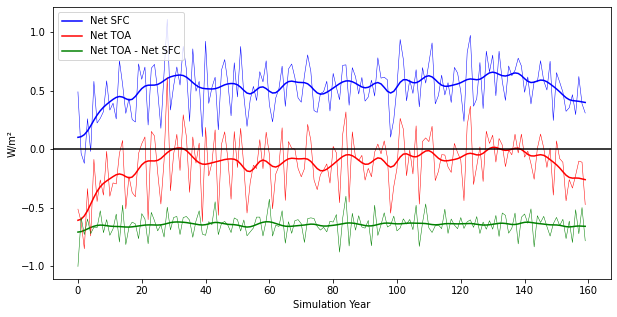

In [53]:
fig, axes = plt.subplots(figsize=figsize)

plt.plot(smooth(surface,len(surface)),color='blue')
plt.plot(smooth(toa,len(toa)),color='red')
plt.plot(smooth(toa-surface,len(toa-surface)),color='green')

plt.plot(surface,linewidth=0.5,color='blue')
plt.plot(toa,linewidth=0.5,color='red')
plt.plot(toa-surface,linewidth=0.5,color='green')


plt.axhline(y=0, color='black', linestyle='-')
plt.ylabel('W/m²')
plt.xlabel('Simulation Year')

axes.legend(['Net SFC', 'Net TOA', 'Net TOA - Net SFC'])